In [71]:
from ast import literal_eval
import ast
import numpy as np
import math
import re
import pandas as pd

import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from difflib import SequenceMatcher
from collections import Counter
import itertools

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from fuzzywuzzy import fuzz
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer, WordNetLemmatizer

pd.set_option('display.max_columns', 1000)

In [38]:
#jaro version
def sort_token_alphabetically(word):
    token = re.split('[,. ]', word)
    sorted_token = sorted(token)
    return ' '.join(sorted_token)

def get_jaro_distance(first, second, winkler=True, winkler_ajustment=True,
                      scaling=0.1, sort_tokens=True):
    """
    :param first: word to calculate distance for
    :param second: word to calculate distance with
    :param winkler: same as winkler_ajustment
    :param winkler_ajustment: add an adjustment factor to the Jaro of the distance
    :param scaling: scaling factor for the Winkler adjustment
    :return: Jaro distance adjusted (or not)
    """
    if sort_tokens:
        first = sort_token_alphabetically(first)
        second = sort_token_alphabetically(second)

    if not first or not second:
        raise JaroDistanceException(
            "Cannot calculate distance from NoneType ({0}, {1})".format(
                first.__class__.__name__,
                second.__class__.__name__))

    jaro = _score(first, second)
    cl = min(len(_get_prefix(first, second)), 4)

    if all([winkler, winkler_ajustment]):  # 0.1 as scaling factor
        return round((jaro + (scaling * cl * (1.0 - jaro))) * 100.0) / 100.0

    return jaro

def _score(first, second):
    shorter, longer = first.lower(), second.lower()

    if len(first) > len(second):
        longer, shorter = shorter, longer

    m1 = _get_matching_characters(shorter, longer)
    m2 = _get_matching_characters(longer, shorter)

    if len(m1) == 0 or len(m2) == 0:
        return 0.0

    return (float(len(m1)) / len(shorter) +
            float(len(m2)) / len(longer) +
            float(len(m1) - _transpositions(m1, m2)) / len(m1)) / 3.0

def _get_diff_index(first, second):
    if first == second:
        pass

    if not first or not second:
        return 0

    max_len = min(len(first), len(second))
    for i in range(0, max_len):
        if not first[i] == second[i]:
            return i

    return max_len

def _get_prefix(first, second):
    if not first or not second:
        return ""

    index = _get_diff_index(first, second)
    if index == -1:
        return first

    elif index == 0:
        return ""

    else:
        return first[0:index]

def _get_matching_characters(first, second):
    common = []
    limit = math.floor(min(len(first), len(second)) / 2)

    for i, l in enumerate(first):
        left, right = int(max(0, i - limit)), int(
            min(i + limit + 1, len(second)))
        if l in second[left:right]:
            common.append(l)
            second = second[0:second.index(l)] + '*' + second[
                                                       second.index(l) + 1:]

    return ''.join(common)

def _transpositions(first, second):
    return math.floor(
        len([(f, s) for f, s in zip(first, second) if not f == s]) / 2.0)

def get_top_matches(reference, value_list, max_results=None):
    scores = []
    if not max_results:
        max_results = len(value_list)
    for val in value_list:
        score_sorted = get_jaro_distance(reference, val)
        score_unsorted = get_jaro_distance(reference, val, sort_tokens=False)
        scores.append((val, max(score_sorted, score_unsorted)))
    scores.sort(key=lambda x: x[1], reverse=True)

    return scores[:max_results]

class JaroDistanceException(Exception):
    def __init__(self, message):
        super(Exception, self).__init__(message)

In [110]:
#load csv
df = pd.read_csv('bo_attr_lookup_new.csv', encoding='latin1')
df['children_org_name'] = df['children_org_name_list']
df = df.dropna()

#conver child col to list
df['children_org_name_list'] = df['children_org_name_list'].map(lambda x: [x])

#jaro score
df['jaro_func_score'] = df[['parent_org_name', 'children_org_name_list']].agg(lambda x: get_top_matches(*x), axis=1)
df['jaro_func_score'] = df.jaro_func_score.apply(lambda x: [val[1] for val in x])
df['jaro_func_score'] = df.jaro_func_score.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)

#create df of just medium and high
df1 = df[df['match_confidence'].isin(['MEDIUM','HIGH'])]

#create low df
df2 = df[df['match_confidence'] == 'LOW']

#create sample of 2k rows of low df
df2 = df2.sample(2000)

#concat dfs
frames = [df1,df2]
df = pd.concat(frames)

df.head()

,parent_org_name,children_org_name_list,match_confidence_score,match_confidence,children_org_name,jaro_func_score
3,+MARTINS,[SAN MARINA],0.750000,MEDIUM,SAN MARINA,0.78
8,111 SOUTH,[1&1 IONOS],0.769231,MEDIUM,1&1 IONOS,0.67
13,247 CUSTOMER PVT. LTD.,[24/7 CUSTOMER PRIVATE LIMITED],0.843750,MEDIUM,24/7 CUSTOMER PRIVATE LIMITED,0.89
18,3M,[3M],1.000000,HIGH,3M,1.00
57,A. K. ENTERPRISE,[ROUSH ENTERPRISE],0.812500,MEDIUM,ROUSH ENTERPRISE,0.79


In [111]:
def total_chars(row):

    results0 = []
    results1 = []
    results2 = []
    results3 = []
    results4 = []
    results5 = []
    
    p = row['parent_org_name'].lower()
    for i in row['children_org_name_list']:
        
        t = i.lower()
        
        dict1 = Counter(p)
        dict2 = Counter(t)
        
        commonDict = dict1 & dict2
        allChars = len(dict1) + len(dict2)
        childCharsPositions = len(t)
        
        results0.append((i, childCharsPositions)[1]) #totalCharacterPositions
        results1.append((i, SequenceMatcher(None, t, p).find_longest_match(0, len(t), 0, len(p))[2])[1]) #consecutiveMatchingChars
        results2.append((i, round(SequenceMatcher(None, t, p).ratio(),2))[1]) #sequence_matcher_ratio
        results3.append((i, sum(int(k==v) for k,v in zip(t, p)))[1]) #countSamePosition
        results4.append((i, allChars)[1])#countTotalUniqueChars
        results5.append((i, len(commonDict))[1]) #countCommonChars

    return pd.Series([results0, results1, results2, results3, results4, results5])

df[['total_chars_positions'
    , 'consecutive_chars'
    , 'sequence_matcher_ratio'
    , 'count_same_position'
    , 'count_total_unique_chars'
    , 'count_common_chars'
   ]]  = df.apply(total_chars, axis=1)

df['total_chars_positions'] = df.total_chars_positions.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)
df['consecutive_chars'] = df.consecutive_chars.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)
df['sequence_matcher_ratio'] = df.sequence_matcher_ratio.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)
df['count_same_position'] = df.count_same_position.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)
df['count_total_unique_chars'] = df.count_total_unique_chars.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)
df['count_common_chars'] = df.count_common_chars.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)

df['percent_matched'] = round(df['count_common_chars'] / df['count_total_unique_chars'],2)
df['percent_same_position'] = round(df['count_same_position'] / df['total_chars_positions'],2)

#remove stop words
stop = stopwords.words('english')
df['parent_org_name'] = df['parent_org_name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['children_org_name'] = df['children_org_name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#apply stemming
porter_stemmer = PorterStemmer()
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df['parent_org_name'] = df['parent_org_name'].apply(stem_sentences)
df['children_org_name'] = df['children_org_name'].apply(stem_sentences)

#remove special characters
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df['parent_org_name'] = df['parent_org_name'].str.replace(char, '')
    df['children_org_name'] = df['children_org_name'].str.replace(char, '')

df.head(10)

,parent_org_name,children_org_name_list,match_confidence_score,match_confidence,children_org_name,jaro_func_score,total_chars_positions,consecutive_chars,sequence_matcher_ratio,count_same_position,count_total_unique_chars,count_common_chars,percent_matched,percent_same_position
3,martin,[SAN MARINA],0.750000,MEDIUM,san marina,0.78,10.0,3.0,0.56,0.0,15.0,6.0,0.40,0.00
8,111 south,[1&1 IONOS],0.769231,MEDIUM,11 iono,0.67,9.0,2.0,0.44,4.0,14.0,4.0,0.29,0.44
13,247 custom pvt ltd,[24/7 CUSTOMER PRIVATE LIMITED],0.843750,MEDIUM,247 custom privat limit,0.89,29.0,12.0,0.78,3.0,36.0,16.0,0.44,0.10
18,3M,[3M],1.000000,HIGH,3M,1.00,2.0,2.0,1.00,2.0,4.0,2.0,0.50,1.00
57,A K enterpris,[ROUSH ENTERPRISE],0.812500,MEDIUM,roush enterpris,0.79,16.0,11.0,0.69,11.0,22.0,8.0,0.36,0.69
58,ab edward enterpris,[A. G. EDWARDS & SONS],0.769231,MEDIUM,A G edward son,0.73,20.0,10.0,0.64,2.0,25.0,9.0,0.36,0.10
70,aap co ltd,[AAP LEHRERFACHVERLAGE],0.900000,HIGH,aap lehrerfachverlag,0.73,21.0,4.0,0.30,4.0,20.0,5.0,0.25,0.19
87,abb,[ABBVIE],0.750000,MEDIUM,abbvi,0.88,6.0,3.0,0.67,3.0,7.0,2.0,0.29,0.50
94,abbvi,[ABBVIE],1.000000,HIGH,abbvi,1.00,6.0,6.0,1.00,6.0,10.0,5.0,0.50,1.00
111,abercrombi fitch,[ABERCROMBIE & FITCH],1.000000,HIGH,abercrombi fitch,0.98,19.0,12.0,0.94,12.0,25.0,12.0,0.48,0.63


In [149]:
#trigram function
def split_str(s, N):
    rmax = np.clip(len(s)-N, a_min=0, a_max=None)
    return [s[0+i:N+i] for i in range(0, rmax+1)]

#arrange dfs and cols
df = df[['parent_org_name'
         ,'children_org_name_list'
         ,'children_org_name'
         ,'jaro_func_score'
         ,'sequence_matcher_ratio'
        ]]
df1 = df[['parent_org_name','jaro_func_score','sequence_matcher_ratio']]
df['parent_trigram'] = df['parent_org_name'].apply(lambda x: split_str(x, 3))
# del df[['jaro_func_score','sequence_matcher_ratio']]

#binarizer option
mlb = MultiLabelBinarizer(sparse_output=True)

mlb_df = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('parent_trigram')),
                index=df.index,
                columns=mlb.classes_))

#create numbers as column names
mlb_df = mlb_df.rename(columns={x:y for x,y in zip(mlb_df.columns,range(0,len(mlb_df.columns)))})

#convert 0,1s to col name
values = np.where(mlb_df.eq(1), mlb_df.columns, mlb_df)
mlb_df = pd.DataFrame(values, columns=mlb_df.columns)

#concat all columns into a list, agg per row, and drop zeros
mlb_df['ohe_locations'] = (mlb_df.iloc[:,5:].astype(str)
 .agg(lambda x: ' '.join(i for i in x if i != '0'), axis=1)
 .str.split()
)

#create new db of relevant cols
# mlb_df = mlb_df[[0,1,'ohe_locations']]

#change column names
# mlb_df.columns = [['parent_org_name','children_org_name_list','ohe_locations']]

#add back in the jaro score from df1
jaro_func_score = list(df1['jaro_func_score'])
sequence_matcher_ratio = list(df1['sequence_matcher_ratio'])
mlb_df['jaro_func_score'] = jaro_func_score
mlb_df['sequence_matcher_ratio'] = sequence_matcher_ratio
mlb_df.drop([3, 4], axis=1, inplace=True)

#convert ohe_locations column
mlb_df['ohe_locations'] = [','.join(map(str, l)) for l in mlb_df['ohe_locations']]
mlb_df['ohe_locations'] = mlb_df['ohe_locations'].str.replace(',', '').astype(float)
mlb_df['ohe_locations_concat'] = mlb_df['ohe_locations']
mlb_df.drop('ohe_locations', axis=1, inplace=True)

mlb_df.head()

,0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,...,5642,5643,5644,5645,5646,5647,5648,5649,5650,5651,5652,5653,5654,5655,5656,5657,5658,5659,5660,5661,5662,5663,5664,5665,5666,5667,5668,5669,5670,5671,5672,5673,5674,5675,5676,5677,5678,5679,5680,5681,5682,5683,5684,5685,5686,5687,5688,5689,5690,5691,5692,5693,5694,5695,5696,5697,5698,5699,5700,5701,5702,5703,5704,5705,5706,5707,5708,5709,5710,5711,5712,5713,5714,5715,5716,5717,5718,5719,5720,5721,5722,5723,5724,5725,5726,5727,5728,5729,5730,5731,5732,5733,5734,5735,5736,5737,5738,5739,5740,5741,5742,5743,5744,5745,5746,5747,5748,5749,5750,5751,5752,5753,5754,5755,5756,5757,5758,5759,5760,5761,5762,5763,5764,5765,5766,5767,5768,5769,5770,5771,5772,5773,5774,5775,5776,5777,5778,5779,5780,5781,5782,5783,5784,5785,5786,5787,5788,5789,5790,5791,5792,5793,5794,5795,5796,5797,5798,5799,5800,5801,5802,5803,5804,5805,5806,5807,5808,5809,5810,5811,5812,5813,5814,5815,5816,5817,5818,5819,5820,5821,5822,5823,5824,5825,5826,5827,5828,5829,5830,5831,5832,5833,5834,5835,5836,5837,5838,5839,5840,5841,5842,5843,5844,5845,5846,5847,5848,5849,5850,5851,5852,5853,5854,5855,5856,5857,5858,5859,5860,5861,5862,5863,5864,5865,5866,5867,5868,5869,5870,5871,5872,5873,5874,5875,5876,5877,5878,5879,5880,5881,5882,5883,5884,5885,5886,5887,5888,5889,5890,5891,5892,5893,5894,5895,5896,5897,5898,5899,5900,5901,5902,5903,5904,5905,5906,5907,5908,5909,5910,5911,5912,5913,5914,5915,5916,5917,5918,5919,5920,5921,5922,5923,5924,5925,5926,5927,5928,5929,5930,5931,5932,5933,5934,5935,5936,5937,5938,5939,5940,5941,5942,5943,5944,5945,5946,5947,5948,5949,5950,5951,5952,5953,5954,5955,5956,5957,5958,5959,5960,5961,5962,5963,5964,5965,5966,5967,5968,5969,5970,5971,5972,5973,5974,5975,5976,5977,5978,5979,5980,5981,5982,5983,5984,5985,5986,5987,5988,5989,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001,6002,6003,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027,6028,6029,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040,6041,6042,6043,6044,6045,6046,6047,6048,6049,6050,6051,6052,6053,6054,6055,6056,6057,6058,6059,6060,6061,6

# Test Code

In [ ]:
# mlb_df['ohe_locations'].apply(lambda x: sum(int(v) for v in ast.literal_eval(x)))
# mlb_df.ohe_locations.map(lambda x: sum(map(int, ast.literal_eval(x))))
# mlb_df['ohe_locations'] = mlb_df['ohe_locations'].str.replace(',', '').astype(float)
cols = mlb_df.iloc[:,3:]
cols
mlb_df[cols] = mlb_df[cols].astype(float)
# mlb_df[cols] = mlb_df[cols].apply(pd.to_numeric, errors='ignore', axis=1).fillna(mlb_df)
# mlb_df[cols] = mlb_df[cols].apply(pd.to_numeric, errors='coerce')
# mlb_df["ohe_locations"].apply(lambda x: len(ast.literal_eval(x)))

In [ ]:
mlb_df.to_csv('mlb_df.csv')
mlb_df = pd.read_csv('mlb_df.csv')
mlb_df.drop('Unnamed: 0', axis=1, inplace=True)
mlb_df

In [173]:
#classification report function and classifiers
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
        y_true=y_test
        , y_pred=y_predictions
        , labels=np.unique(y_pred)
    )

    avg = list(precision_recall_fscore_support(
            y_true=y_test, 
            y_pred=y_predictions,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['avg / total'] = avg

    return class_report_df.T

classifiers = {
    "Naive Bayes": GaussianNB(),
    "LogisiticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
}

Classification Report: 



ValueError: Unknown label type: (array([4.24000000e+002, 5.38000000e+002, 5.44000000e+002, ...,
       8.12596265e+272, 2.86977121e+281, 1.43151167e+287]),)

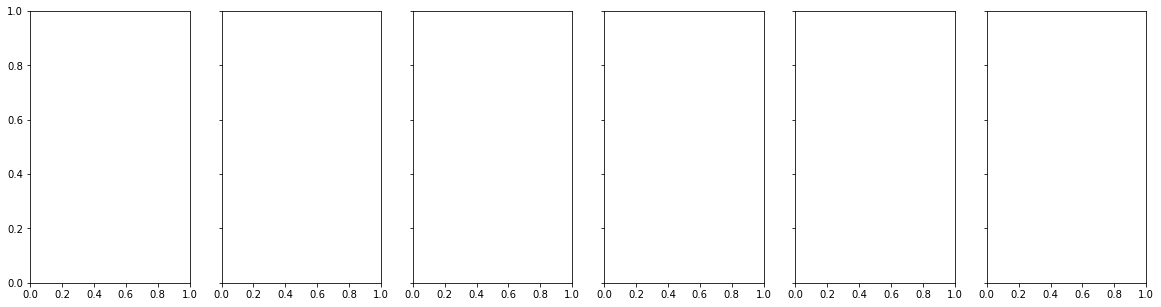

In [174]:
import warnings
warnings.filterwarnings('always')

f, axes = plt.subplots(1, 6, figsize=(20, 5), sharey='row')

print('Classification Report: \n')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    y_predictions = classifier.predict(X_test)
    df_class_report = pandas_classification_report(y_true=y_test, y_pred=y_predictions)
    print((classifier),'\n',df_class_report)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
#                                   display_labels=)
    disp.plot(ax=axes[i], xticks_rotation=0)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')
        
f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

# Parent df stuff - count unique items in list

In [42]:
parent_df = pd.DataFrame(' '.join(df['parent_org_name'].tolist()), columns=['parent_org_name'], index=[0])
parent_df['parent_trigram'] = parent_df['parent_org_name'].apply(lambda x: split_str(x, 3))
parent_df

,parent_org_name,parent_trigram
0,+MARTINS 111 SOUTH 247 CUSTOMER PVT. LTD. 3M A...,"[+MA, MAR, ART, RTI, TIN, INS, NS , S 1, 11, ..."


In [43]:
parent_df = parent_df[['parent_trigram']]

,parent_trigram
0,"[+MA, MAR, ART, RTI, TIN, INS, NS , S 1, 11, ..."


In [61]:
#number of trigrams
parent_df.parent_trigram.str.len().sum()

110150

In [66]:
#number of unique trigrams
parent_explode_df = parent_df['parent_trigram'].explode()
parent_explode_df = pd.DataFrame(parent_explode_df)

,parent_trigram
0,+MA
0,MAR
0,ART
0,RTI
0,TIN
...,...
0,IRA
0,RA
0,A S
0,S


In [67]:
parent_explode_df.parent_trigram.nunique()

6473

In [41]:
parent_list = parent_df.parent_trigram.tolist()
perent_list

NameError: name 'perent_list' is not defined

In [28]:
parent_list = list(df.parent_org_name)

def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

In [ ]:
#factorize option (fastest)
v = df.parent_trigram.values
l = [len(x) for x in v.tolist()]
f, u = pd.factorize(np.concatenate(v))
n, m = len(v), u.size
i = np.arange(n).repeat(l)

dummies = pd.DataFrame(
    np.bincount(i * m + f, minlength=n * m).reshape(n, m),
    df.index, u
)

df.drop('parent_trigram', 1).join(dummies)

In [ ]:
#get dummies option
df.drop('parent_trigram', 1).join(df.parent_trigram.str.join('|').str.get_dummies())

In [ ]:
#put all 100k list trigrams on y axis
ohe_df = pd.DataFrame(data=df, columns=parent_list)
ohe_df.head()

In [ ]:
#attempts to convert 0,1s to column name
mlb_df.loc[:,1:]  * mlb_df.columns[1:].astype(int)
for col in mlb_df.columns:
    mlb_df.loc[mlb_df[col] == 1, col] = col

In [ ]:
#create df with all trigrams as columns

df1 = df[['parent_org_name']]

ohe_df = pd.concat([df1, ohe_df], axis=1, sort=False)
ohe_df.head()

In [ ]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(df[['parent_org_name']]).toarray())

# merge with main df bridge_df on key values
df1 = df.join(enc_df)
df1.head()

In [ ]:
types = df.applymap(type)
types

In [29]:
find_ngrams(parent_list, 3)

In [30]:
input_list = ['all', 'this', 'happened', 'more', 'or', 'less']

keywords = [''.join(i) for i in itertools.product(input_list, repeat = 3)]
vector = CountVectorizer(analyzer='char', ngram_range=(3,3), vocabulary=keywords)
tr_test = vector.transform(['word1'])
print(tr_test)
print(vector)


CountVectorizer(analyzer='char', ngram_range=(3, 3),
                vocabulary=['allallall', 'allallthis', 'allallhappened',
                            'allallmore', 'allallor', 'allallless',
                            'allthisall', 'allthisthis', 'allthishappened',
                            'allthismore', 'allthisor', 'allthisless',
                            'allhappenedall', 'allhappenedthis',
                            'allhappenedhappened', 'allhappenedmore',
                            'allhappenedor', 'allhappenedless', 'allmoreall',
                            'allmorethis', 'allmorehappened', 'allmoremore',
                            'allmoreor', 'allmoreless', 'allorall', 'allorthis',
                            'allorhappened', 'allormore', 'alloror',
                            'allorless', ...])


In [ ]:
ohe_df['parent_org_name'] = ohe_df.parent_org_name.astype(str)

for c in ohe_df['parent_org_name']:
    ohe_df[c] = ohe_df['parent_org_name'].apply(lambda x: int(c in x))
    print (ohe_df)

In [34]:
#trigram function
def split_str(s, N):
    rmax = np.clip(len(s)-N, a_min=0, a_max=None)
    return [s[0+i:N+i] for i in range(0, rmax+1)]

df['parent_org_name'].apply(lambda x: split_str(x, 3))
# input_list.apply(lambda x: split_str(x, 3))

3                           [+MA, MAR, ART, RTI, TIN, INS]
8                      [111, 11 , 1 S,  SO, SOU, OUT, UTH]
13       [247, 47 , 7 C,  CU, CUS, UST, STO, TOM, OME, ...
18                                                    [3M]
57       [A. , . K,  K., K. , . E,  EN, ENT, NTE, TER, ...
                               ...                        
10303    [NAT, ATO, TOM, OMA, MAS, AS , S S,  SC, SCH, ...
11965    [RAD, ADI, DIU, IUS, US , S H,  HE, HEA, EAL, ...
809      [AME, MER, ERI, RIC, ICA, CAN, AN , N M,  MU, ...
840      [AMI, MIX, IXC, XCO, COM, OM , M I,  IN, INC, ...
4533                                  [DEV, EVI, VID, IDA]
Name: parent_org_name, Length: 5210, dtype: object

In [15]:
def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input)-n+1):
        output.append(input[i:i+n])
    return output

In [17]:
ngrams(df.parent_org_name, 3)

AttributeError: 'Series' object has no attribute 'split'

In [18]:
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

In [20]:
find_ngrams(input_list,1)

In [14]:
words = nltk.word_tokenize('this is a string')
my_bigrams = nltk.bigrams(words)
my_trigrams = nltk.trigrams(words)

In [20]:
my_bigrams

<generator object bigrams at 0x7fe9a7255890>

In [16]:
from collections import deque
from itertools import islice

def ngrams(message, n=1):
    it = iter(message.split())
    window = deque(islice(it, n), maxlen=n)
    yield tuple(window)
    for item in it:
        window.append(item)
        yield tuple(window)

In [17]:
ngrams(input_list,3)

<generator object ngrams at 0x7fe9a7255120>

In [21]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
text = "Hi How are you? i am fine and you"
token=nltk.word_tokenize(text)
bigrams=ngrams(token,2)

In [22]:
bigrams

<generator object ngrams at 0x7fe9a7278ac0>

In [44]:
parent_list = str(df.parent_org_name)
parent_list

'3                                  +MARTINS\n8                                 111 SOUTH\n13                   247 CUSTOMER PVT. LTD.\n18                                       3M\n57                         A. K. ENTERPRISE\n                        ...                \n10303               NATOMAS SCHOOL DISTRICT\n11965                     RADIUS HEALTH INC\n809      AMERICAN MUSEUM OF NATURAL HISTORY\n840                            AMIXCOM INC.\n4533                                 DEVIDA\nName: parent_org_name, Length: 5210, dtype: object'

In [46]:
parent_org_name_string = pd.DataFrame(' '.join(df['parent_org_name'].tolist()), columns=['parent_org_name'], index=[0])

In [51]:
parent_org_name_string = pd.DataFrame(' '.join(df['parent_org_name'].tolist()), columns=['parent_org_name'], index=[0])
parent_org_name_string['parent_trigram'] = parent_org_name_string['parent_org_name'].apply(lambda x: split_str(x, 3))
parent_org_name_string

,parent_org_name,parent_trigram
0,+MARTINS 111 SOUTH 247 CUSTOMER PVT. LTD. 3M A...,"[+MA, MAR, ART, RTI, TIN, INS, NS , S 1, 11, ..."


In [ ]:
print('original df shape: \n', df.shape)
print('')

print('dtypes: \n', df.dtypes)
print('')

print('original match confidence bins values counts: \n', df.match_confidence.value_counts())
print('')

#create df of just medium and high
df1 = df[df['match_confidence'].isin(['MEDIUM','HIGH'])]
print('high low df shape: \n', df1.shape)
print('high and low df value counts: \n', df1.match_confidence.value_counts())
print('')

#create low df
df2 = df[df['match_confidence'] == 'LOW']
print('low df shape: \n', df2.shape)
print('')

#create sample of 2k rows of low df
df2 = df2.sample(2000)

#concat dfs
frames = [df1,df2]
df = pd.concat(frames)
print('new df shape with sample of 2k low rows: \n', df.shape)
print('new df value counts: \n', df.match_confidence.value_counts())
print(df.head())